<a href="https://www.kaggle.com/code/khoshbayani/predict-based-on-near-neighbors?scriptVersionId=139771107" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Hi!
I hope this practice I did will be viewed and given feedback.

Let me clear what I want to do in this notebook.
The main idea is to take the new price list from the user and guess which of the previous years is more similar to this input data. and predict the price in the coming weeks according to the charts of the previous years.

Ok
Let's start coding. 
first of all we import necessary libraries.
I make warnings disappeared by importing warnings and writing this line "warnings.filterwarnings('ignore')".

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
data= pd.read_csv('/kaggle/input/tomato-daily-prices/Tomato.csv')
data.head()

,Date,Unit,Minimum,Maximum,Average,Market
0,2013-06-16,Kg,26,32,29.0,Tomato
1,2013-06-17,Kg,20,25,22.5,Tomato
2,2013-06-18,Kg,22,26,24.0,Tomato
3,2013-06-19,Kg,24,28,26.0,Tomato
4,2013-06-20,Kg,22,26,24.0,Tomato


We make new columns: "Week' and "Year"

In [2]:
data['Year']=pd.to_datetime(data.Date).dt.isocalendar().year
data['Week']=pd.to_datetime(data.Date).dt.isocalendar().week

All we need of this datafram are "Year" and "week" and "Average" columns.

In [3]:
data = data[['Year','Week','Average']]

In [4]:
grouped = data.groupby(['Year','Week'])['Average'].mean().reset_index()

In [5]:
grouped

,Year,Week,Average
0,2013,24,29.000000
1,2013,25,22.800000
2,2013,26,23.400000
3,2013,27,17.600000
4,2013,28,37.700000
...,...,...,...
408,2021,15,20.214286
409,2021,16,14.428571
410,2021,17,21.428571
411,2021,18,13.928571


As you can see the weeks list of every year doesn't contain full list of 0 to 53 (plus 53 itself).
It means there are some hidden none values.
To make full list of weeks of each year we make a datafram with Nan values and move values from grouped datafram to new datafram.
We follow two steps to do it:

step 1:
creating none_df.

In [6]:
number_of_unique_years  = len(grouped.Year.unique())
number_of_weeks_of_a_year =  53   #based on isocalendar's document each year has 53 weeks.
number_of_rows = number_of_unique_years * number_of_weeks_of_a_year
number_of_columns=len(grouped.columns)
none_df=pd.DataFrame(np.zeros((number_of_rows,number_of_columns)),columns=grouped.columns).replace(0.0,np.nan)
none_df.shape

(477, 3)

step 2:
moving Average columnn's values from grouped dataframe to none_df.
At last we know none_df as result_df.

In [7]:
years_unique_list=list(grouped.Year.unique())
for year in years_unique_list:
    week_list_of_year=np.asarray(grouped[grouped.Year == year]['Week'])
    for week in week_list_of_year:
        average=np.asarray(grouped[grouped.Year == year][grouped.Week ==week]['Average'])[0]
        year_index = years_unique_list.index(year)
        which_row_index = (year_index*number_of_weeks_of_a_year)  +  week
        none_df.iloc[which_row_index]['Average'] = average

else:
    none_df['Year'] = sorted(list(years_unique_list * 53))
    none_df['Week'] = list(range(1,54)) * (number_of_unique_years)
    result_df = none_df

In [8]:
result_df

,Year,Week,Average
0,2013,1,NaN
1,2013,2,NaN
2,2013,3,NaN
3,2013,4,NaN
4,2013,5,NaN
...,...,...,...
472,2021,49,NaN
473,2021,50,NaN
474,2021,51,NaN
475,2021,52,NaN


Now we want to calculate how percent each year has nan values.

In [9]:
for year in years_unique_list:
    print('nan for',year,'is:',round(100*sum(result_df[result_df['Year']==year].Average.isna())/53),'%')



nan for 2013 is: 45 %
nan for 2014 is: 2 %
nan for 2015 is: 2 %
nan for 2016 is: 0 %
nan for 2017 is: 2 %
nan for 2018 is: 2 %
nan for 2019 is: 2 %
nan for 2020 is: 4 %
nan for 2021 is: 62 %


As we can see nan percents of 2013 and 2021 are not acceptable. So I decided to remove this years' rows from dataset.

In [10]:
chosen_year_result_df=result_df[result_df['Year']!=2013 ][ result_df['Year']!=2021].reset_index(drop=True)

In [11]:
chosen_year_result_df

,Year,Week,Average
0,2014,1,NaN
1,2014,2,32.500000
2,2014,3,31.916667
3,2014,4,31.200000
4,2014,5,20.166667
...,...,...,...
366,2020,49,44.428571
367,2020,50,49.142857
368,2020,51,51.214286
369,2020,52,39.642857


Now we fill nan with KNN Imputer.

In [12]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=2)
knn_result_array = knn_imputer.fit_transform(chosen_year_result_df)

In [13]:
knn_result_df=pd.DataFrame(knn_result_array,columns=chosen_year_result_df.columns)

In [14]:
knn_result_df

,Year,Week,Average
0,2014.0,1.0,35.392857
1,2014.0,2.0,32.500000
2,2014.0,3.0,31.916667
3,2014.0,4.0,31.200000
4,2014.0,5.0,20.166667
...,...,...,...
366,2020.0,49.0,44.428571
367,2020.0,50.0,49.142857
368,2020.0,51.0,51.214286
369,2020.0,52.0,39.642857


the proof that we don't have any nan in knn_result_df:

In [15]:
sum(knn_result_df.Average.isna())

0

We know each year contain weeks from 1 to 53 with no exception. So we can ignore Week column.

In [16]:
Year_and_Average = knn_result_df[['Year','Average']].reset_index(drop=True)

In [17]:
Year_and_Average

,Year,Average
0,2014.0,35.392857
1,2014.0,32.500000
2,2014.0,31.916667
3,2014.0,31.200000
4,2014.0,20.166667
...,...,...
366,2020.0,44.428571
367,2020.0,49.142857
368,2020.0,51.214286
369,2020.0,39.642857


We want to compare the changes of each prices list.
**The changes of prices list means point to point slope of its diagram. that we call it "M".**

Add "M" column:

In [18]:
knn_result_df['M'] = np.nan
len_knn_result_df= len(knn_result_df)
for i in range(len_knn_result_df):
    if i<(len_knn_result_df-1):
        if (knn_result_df['Year'][i+1]-knn_result_df['Year'][i])==0:
            m=((knn_result_df['Average'][i+1]-knn_result_df['Average'][i])/(knn_result_df['Week'][i+1]-knn_result_df['Week'][i]))
            knn_result_df['M'][i+1]= m
    else:
        break

The number of "M" column is less than "Week" column.
So we leave first "M" of each year as nan.

In [19]:
knn_result_df

,Year,Week,Average,M
0,2014.0,1.0,35.392857,NaN
1,2014.0,2.0,32.500000,-2.892857
2,2014.0,3.0,31.916667,-0.583333
3,2014.0,4.0,31.200000,-0.716667
4,2014.0,5.0,20.166667,-11.033333
...,...,...,...,...
366,2020.0,49.0,44.428571,-0.571429
367,2020.0,50.0,49.142857,4.714286
368,2020.0,51.0,51.214286,2.071429
369,2020.0,52.0,39.642857,-11.571429


Changing type of columns.
about year's column, we change it to int to remove float's point and then convert it to object.

In [20]:
knn_result_df['Year'] = knn_result_df['Year'].astype('int')
knn_result_df['Year'] = knn_result_df['Year'].astype('object')
knn_result_df['Week'] = knn_result_df['Week'].astype('int')

In [21]:
knn_result_df.dtypes

Year        object
Week         int64
Average    float64
M          float64
dtype: object

In [22]:
knn_result_df

,Year,Week,Average,M
0,2014,1,35.392857,NaN
1,2014,2,32.500000,-2.892857
2,2014,3,31.916667,-0.583333
3,2014,4,31.200000,-0.716667
4,2014,5,20.166667,-11.033333
...,...,...,...,...
366,2020,49,44.428571,-0.571429
367,2020,50,49.142857,4.714286
368,2020,51,51.214286,2.071429
369,2020,52,39.642857,-11.571429


In [23]:
Year_and_M_df = knn_result_df[['Year','M']].dropna().reset_index(drop=True)
Year_and_M_df

,Year,M
0,2014,-2.892857
1,2014,-0.583333
2,2014,-0.716667
3,2014,-11.033333
4,2014,1.333333
...,...,...
359,2020,-0.571429
360,2020,4.714286
361,2020,2.071429
362,2020,-11.571429


In [24]:
X = []
y = []
chosen_year_unique_list = Year_and_M_df['Year'].unique()
for year in chosen_year_unique_list:
    data_based_on_year = Year_and_M_df[Year_and_M_df['Year'] == year]
    X.append(np.asarray(data_based_on_year['M']))
    y.append(year)



X is list of array of "M" values of a year.

y is list of unique years

In [25]:
X = np.asarray(X)
y = np.asarray(y)

Important: the cell below created to make input data

In [26]:
input_year = 2015 #int(input('input year please (valid inputs:2014,2015,2016,2017,2018,2019,2020):'))
input_start = 12 # int(input('input start please(valid inputs: 0 to 53):'))
input_end = 50 #int(input('input end please:(valid inputs: 0 to 53)'))
a_input = 1.06# float(input('input \'a\' please(e.g. 1.06):'))

if input_end>number_of_weeks_of_a_year:
    raise IndexError("The maximum amount of \'input_end\' is: 53")

input_averages_row = np.asarray(knn_result_df[knn_result_df.Year == input_year]['Average'][input_start:input_end]) * a_input

In [27]:
print(input_end)

50


In [28]:
input_averages_row

array([52.54571429, 53.90857143, 38.08428571, 36.04      , 35.35857143,
       39.37142857, 38.00857143, 54.325     , 40.73428571, 52.24285714,
       75.71428571, 57.92142857, 51.48571429, 39.37142857, 40.88571429,
       45.20142857, 58.3       , 61.32857143, 56.78571429, 52.16714286,
       67.08285714, 60.49571429, 42.02142857, 51.48571429, 36.94857143,
       31.27      , 31.72428571, 26.04571429, 24.60714286, 22.18428571,
       21.04857143, 33.31428571, 25.66714286, 45.35285714, 67.31      ,
       54.21142857, 66.62857143, 54.43857143])

In [29]:
input_m_row = []

for i in range((len(input_averages_row)-1)):
    input_m_row.append(input_averages_row[(i+1)]-input_averages_row[i])


In [30]:
X=np.append(X[:,input_start:(input_start+len(input_m_row))],[input_m_row],axis=0)

To find that the data that we get from user is more similar to which year of our dataset we use **NearestNeighbors** :

In [31]:
from sklearn.neighbors import NearestNeighbors
nbr = NearestNeighbors(n_neighbors=6)
nbr.fit(X)

NearestNeighbors(n_neighbors=6)

In [32]:
nbr.kneighbors(X,return_distance=False)

array([[0, 6, 2, 4, 1, 7],
       [1, 7, 4, 2, 0, 3],
       [2, 4, 0, 1, 7, 5],
       [3, 4, 5, 2, 1, 0],
       [4, 2, 1, 0, 3, 7],
       [5, 3, 4, 2, 0, 1],
       [6, 0, 2, 4, 3, 1],
       [7, 1, 4, 2, 0, 3]])

In [33]:
near_array = np.asarray(nbr.kneighbors(X,return_distance=False)[-1])
near_array[near_array<7]

array([1, 4, 2, 0, 3])

In [34]:
near_list=list(near_array[near_array<7])
near_list

[1, 4, 2, 0, 3]

In [35]:
near_years_list= chosen_year_unique_list[near_list]
near_years_list

array([2015, 2018, 2016, 2014, 2017], dtype=object)

In [36]:
# just to know the index0 shows the "nearest_neighbor_year"
# nearest_neighbor_year = near_years_list[0]

In [37]:
near_average_list_for_1nb = np.asarray(Year_and_Average[Year_and_Average.Year == near_years_list[0]].Average)
near_average_list_for_2nb = np.asarray(Year_and_Average[Year_and_Average.Year == near_years_list[1]].Average)

We make "near_average_list_for_1nb" 2 times more effective than "near_average_list_for_2nb" :

In [38]:
X_for_reg= np.append(np.asarray([near_average_list_for_1nb]*10),np.asarray([near_average_list_for_2nb]*5),axis=0)

In [39]:
# X_for_reg

To predict based on nearest neighbors we will use LinearRegression

In [40]:
from sklearn.linear_model import LinearRegression
linearR= LinearRegression()
linearR.fit(list([range(53)] * 15),X_for_reg)

LinearRegression()

In [41]:
predicted_price_list=linearR.predict([range(53)]).reshape(-1)

We check how many times the new data is the regression output on average. We call it "a" :

In [42]:
a = (input_averages_row/predicted_price_list[input_start:input_end]).mean()

We will shift input data to put it in its place:

In [43]:
shifted_input_average_row_with_none=[]
for none in range(input_start-1):
    shifted_input_average_row_with_none.append(None)
else:
    for inp_ave in input_averages_row:
        shifted_input_average_row_with_none.append(inp_ave)

In [44]:
shifted_input_average_row_with_none

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 52.54571428571428,
 53.90857142857143,
 38.08428571428572,
 36.04,
 35.35857142857143,
 39.371428571428574,
 38.00857142857143,
 54.325,
 40.73428571428572,
 52.24285714285715,
 75.71428571428572,
 57.92142857142858,
 51.48571428571429,
 39.371428571428574,
 40.885714285714286,
 45.20142857142858,
 58.300000000000004,
 61.32857142857143,
 56.785714285714285,
 52.16714285714286,
 67.08285714285715,
 60.495714285714286,
 42.02142857142858,
 51.48571428571429,
 36.94857142857143,
 31.270000000000003,
 31.724285714285713,
 26.04571428571429,
 24.60714285714286,
 22.184285714285714,
 21.04857142857143,
 33.31428571428572,
 25.66714285714286,
 45.35285714285715,
 67.31,
 54.21142857142858,
 66.62857142857143,
 54.43857142857143]

By the cell below we will see the plot of regression output (predicted plot) and input data plot.

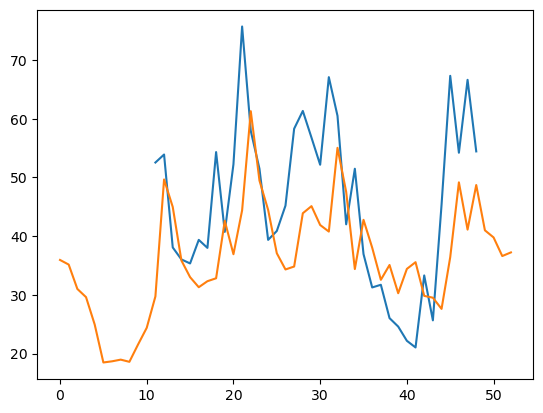

In [45]:
plt.plot(range(len(shifted_input_average_row_with_none)),shifted_input_average_row_with_none)
plt.plot(range(53),predicted_price_list)
plt.show()

Check if prediction was correct :

In [46]:
print('predicted neighbor years:',near_years_list[:2])
print('input year:',input_year)

predicted neighbor years: [2015 2018]
input year: 2015


To make a better plot 
we make predicted_price_list connected to input average plot

In [47]:
if input_start>0:
    predicted_price_list[input_start-1] = shifted_input_average_row_with_none[input_start-1]/a

    
predicted_price_list[(len(shifted_input_average_row_with_none)-1)] = shifted_input_average_row_with_none[(len(shifted_input_average_row_with_none)-1)]/a

predicted_price_list[input_start:input_end-2] = None

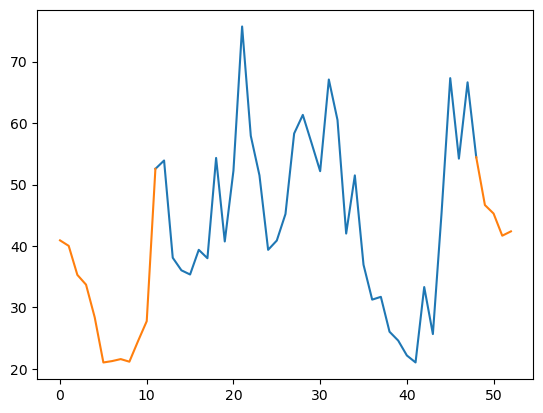

In [48]:
plt.plot(range(len(shifted_input_average_row_with_none)),shifted_input_average_row_with_none)
plt.plot(range(53),a*predicted_price_list)
plt.show()

The End